In [25]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

# Load the saved models
knn = joblib.load('knn_model.pkl')
rf = joblib.load('rf_model.pkl')

print("✓ Models loaded successfully!")

✓ Models loaded successfully!


In [26]:
#LOAD DATA
df = pd.read_csv('Library_woAVG.csv')

#DROP HIDDEN NETWORKS and HOTSPOTS
df = df[df['SSID'] != 'Hidden_Network']
hotspot = ['iPhone', 'Android', 'Galaxy', 'Xiaomi', 'Pixel', 'Redmi', 'Brian', 'æ©æ©æ©æ©ç',
            'DIRECT-', 'Chris', 'Personal', 'Skyler', 'phone', 'Benben', 'Loser', 'årrrrrrr' ,'å²',
            'èæé²', 'ð«â­ï¸â¨â¡ï¸ð«', 'XxxxxxxX', 'general_7006', 'vivo Y38 5G', 'Calvin']

#count appereances
appearances = df.groupby('SSID')['Location'].nunique()

#keep ssids that appear in 70% of locations
threshold = 0.7*df['Location'].nunique()
common_ssids = appearances[appearances >= threshold].index

filtered_df = df[df['SSID'].isin(common_ssids)].copy() 
for keyword in hotspot:
    filtered_df = filtered_df[~filtered_df['SSID'].str.contains(keyword, case=False, na=False)]

#PIVOT THE DATA
pivot_table = filtered_df.pivot_table(
    index=['Scan_ID','Location', 'Run'],      
    columns='SSID',     
    values='Signal(dBm)', 
    aggfunc='mean',        
    fill_value=-100 
)

X = pivot_table.values  #features, the parameters
y = pivot_table.index.get_level_values('Location')   #labels, what is going to be predicted

print(f"✓ Data loaded: {len(X)} samples across {len(set(y))} zones")

✓ Data loaded: 500 samples across 5 zones


In [27]:
# Let's pick a few interesting samples to demonstrate
# We'll choose one from each zone
print("\n[2] Selecting test samples from each zone...")

# Get unique zones
zones = list(set(y))
print(f"Zones in library: {zones}")

# Pick one random sample from each zone
test_indices = []
for zone in zones:
    zone_indices = [i for i, label in enumerate(y) if label == zone]
    test_indices.append(zone_indices[0])  # Take first sample from each zone

print(f"\n✓ Selected {len(test_indices)} test samples (one per zone)")


[2] Selecting test samples from each zone...
Zones in library: ['MainStairs/TopPicks', 'TopPicks/Audiovisual', 'LaptopPriority/CurrentPeriodicals', 'Stairs/RightEnd', 'Hallway/LeftEnd']

✓ Selected 5 test samples (one per zone)


In [29]:
# Make predictions
print("\n[3] Making predictions with both models...")

X_test_samples = X[test_indices]
y_test_samples = [y[i] for i in test_indices]

knn_predictions = knn.predict(X_test_samples)
rf_predictions = rf.predict(X_test_samples)

# Show results
print("\n" + "="*80)
print("PREDICTION RESULTS")
print("="*80)

for i in range(len(test_indices)):
    actual = y_test_samples[i]
    knn_pred = knn_predictions[i]
    rf_pred = rf_predictions[i]
    
    print(f"\nSample {i+1}:")
    print(f"  Actual Zone:    {actual}")
    print(f"  k-NN predicts:  {knn_pred} {'✓' if knn_pred == actual else '✗'}")
    print(f"  RF predicts:    {rf_pred} {'✓' if rf_pred == actual else '✗'}")
    
    if knn_pred != rf_pred:
        print(f"  ⚠️  Models disagree!")

print("\n" + "="*80)


[3] Making predictions with both models...

PREDICTION RESULTS

Sample 1:
  Actual Zone:    MainStairs/TopPicks
  k-NN predicts:  MainStairs/TopPicks ✓
  RF predicts:    MainStairs/TopPicks ✓

Sample 2:
  Actual Zone:    TopPicks/Audiovisual
  k-NN predicts:  TopPicks/Audiovisual ✓
  RF predicts:    TopPicks/Audiovisual ✓

Sample 3:
  Actual Zone:    LaptopPriority/CurrentPeriodicals
  k-NN predicts:  LaptopPriority/CurrentPeriodicals ✓
  RF predicts:    LaptopPriority/CurrentPeriodicals ✓

Sample 4:
  Actual Zone:    Stairs/RightEnd
  k-NN predicts:  Stairs/RightEnd ✓
  RF predicts:    Stairs/RightEnd ✓

Sample 5:
  Actual Zone:    Hallway/LeftEnd
  k-NN predicts:  Hallway/LeftEnd ✓
  RF predicts:    Hallway/LeftEnd ✓



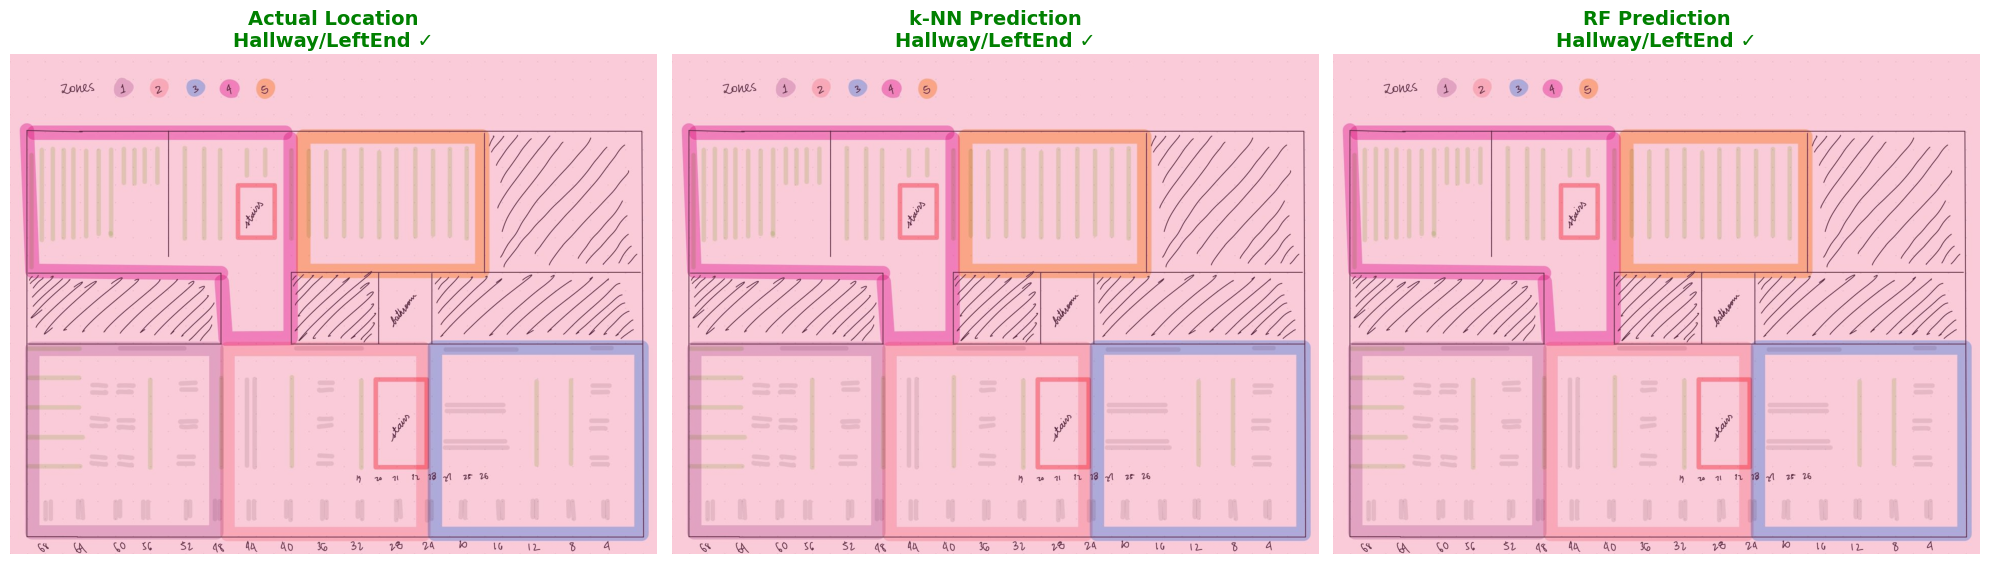


Showing Sample 5
Both models agree: Yes


In [36]:
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba

# Load the library map
img = Image.open('images/library_layout.jpg')

# Define colors for each zone (matching your map)
zone_colors = {
    'LaptopPriority/CurrentPeriodicals': (0.4, 0.7, 1.0, 0.3),  # Blue with transparency
    'MainStairs/TopPicks': (1.0, 0.5, 0.5, 0.3),  # Coral
    'TopPicks/Audiovisual': (0.7, 0.5, 0.8, 0.3),  # Purple
    'Hallway/LeftEnd': (1.0, 0.4, 0.7, 0.3),  # Pink
    'Stairs/RightEnd': (1.0, 0.7, 0.3, 0.3)  # Orange
}

# Pick a sample to visualize (change this number to show different samples)
sample_idx = 4

actual_zone = y_test_samples[sample_idx]
knn_zone = knn_predictions[sample_idx]
rf_zone = rf_predictions[sample_idx]

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

titles = [f'Actual Location\n{actual_zone}', 
          f'k-NN Prediction\n{knn_zone}', 
          f'RF Prediction\n{rf_zone}']
zones = [actual_zone, knn_zone, rf_zone]

for ax, title, zone in zip(axes, titles, zones):
    ax.imshow(img)
    
    # Add colored overlay for the zone
    overlay = np.zeros((*img.size[::-1], 4))
    if zone in zone_colors:
        overlay[:, :] = zone_colors[zone]
    
    ax.imshow(overlay)
    
    # Title with checkmark or X
    is_correct = (zone == actual_zone)
    symbol = '✓' if is_correct else '✗'
    color = 'green' if is_correct else 'red'
    
    ax.set_title(title + f' {symbol}', fontsize=14, fontweight='bold', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nShowing Sample {sample_idx + 1}")
print(f"Both models agree: {'Yes' if knn_zone == rf_zone else 'No'}")